# CIFAR-10 Image Classification Project

- It consists of 60000 32x32 colour images

- This data offers 10 classes for classification, with 6000 images per class.

- There are 50000 training images and 10000 test images.

- Here are the classes in the dataset, as well as 10 random images from each:

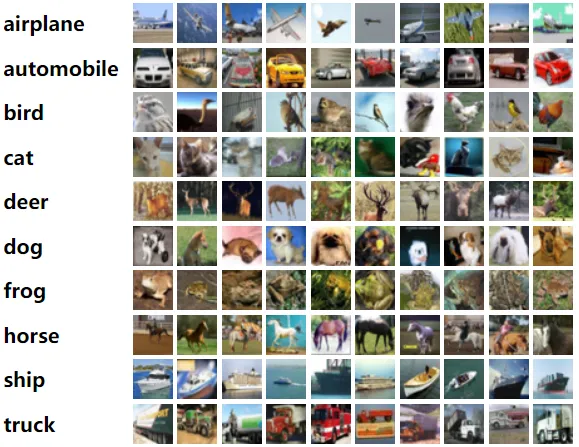

## 1- Importing Libraries

In [1]:
# Import libraries for CIFAR-10 dataset classification by pretrained CNN ResNet50

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 

from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import json



/Users/amna/Documents/Data Analytics/Projects/4. Computer_Vision Project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 2- Load Dataset
In this step, we load the CIFAR-10 dataset using TensorFlow's built-in dataset loader. The CIFAR-10 dataset consists of 60,000 color images in 10 classes, with 50,000 images for training and 10,000 for testing. Loading the dataset provides us with the images and their corresponding labels, which we will use for training and evaluating our model. We also check the shape of the data to ensure it has been loaded correctly.

In [2]:
# load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Check the shape of the dataset
print("Training data shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test data shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)



Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


### 2.1 - Limit Dataset
To speed up training and reduce computational requirements, we will use a subset of the CIFAR-10 dataset. Specifically, we will limit the training set to 10,000 images and the test set to 2,000 images. This allows for faster experimentation while still providing enough data to evaluate model performance.

In [3]:
# Limit data 10000 and take 30000 for faster training

train_images = train_images[:30000]
train_labels = train_labels[:30000]


Label: 7, Count: 3042
Label: 1, Count: 3023
Label: 6, Count: 3016
Label: 3, Count: 3008
Label: 2, Count: 3007
Label: 4, Count: 2999
Label: 9, Count: 2995
Label: 0, Count: 2983
Label: 8, Count: 2973
Label: 5, Count: 2954


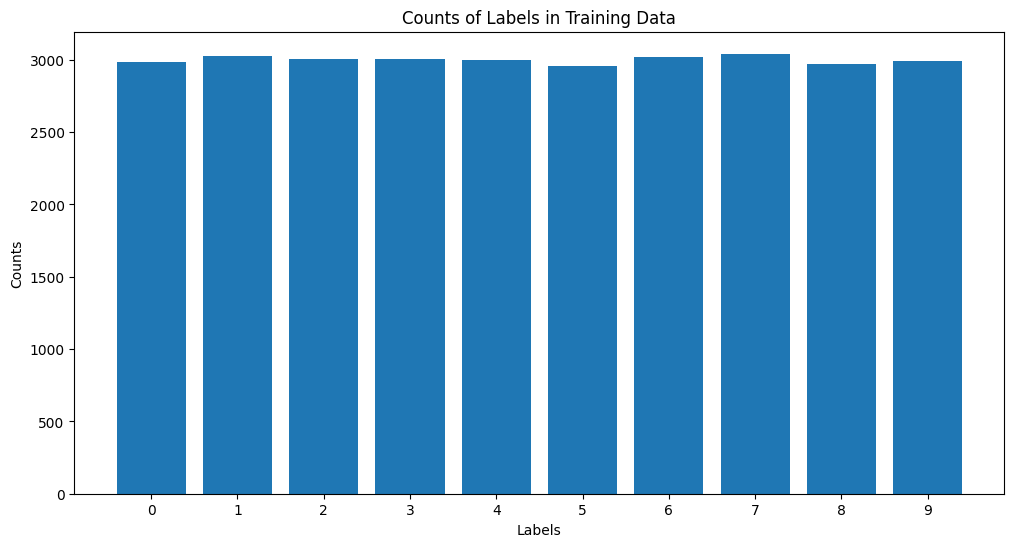

In [4]:
# value count of labels
unique, counts = np.unique(train_labels, return_counts=True)

# Print the unique labels and their counts in descending order
for label, count in sorted(zip(unique, counts), key=lambda x: x[1], reverse=True):
    print(f"Label: {label}, Count: {count}")

# Visualize counts of labels
plt.figure(figsize=(12, 6))
plt.bar(unique, counts)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Counts of Labels in Training Data')
plt.xticks(unique)
plt.show()



### 2.2 - Visualize Data
Next, we visualize a sample of the training images to better understand the dataset and verify that the data has been loaded correctly. This step also helps us become familiar with the different classes and the variety of images present in each class.

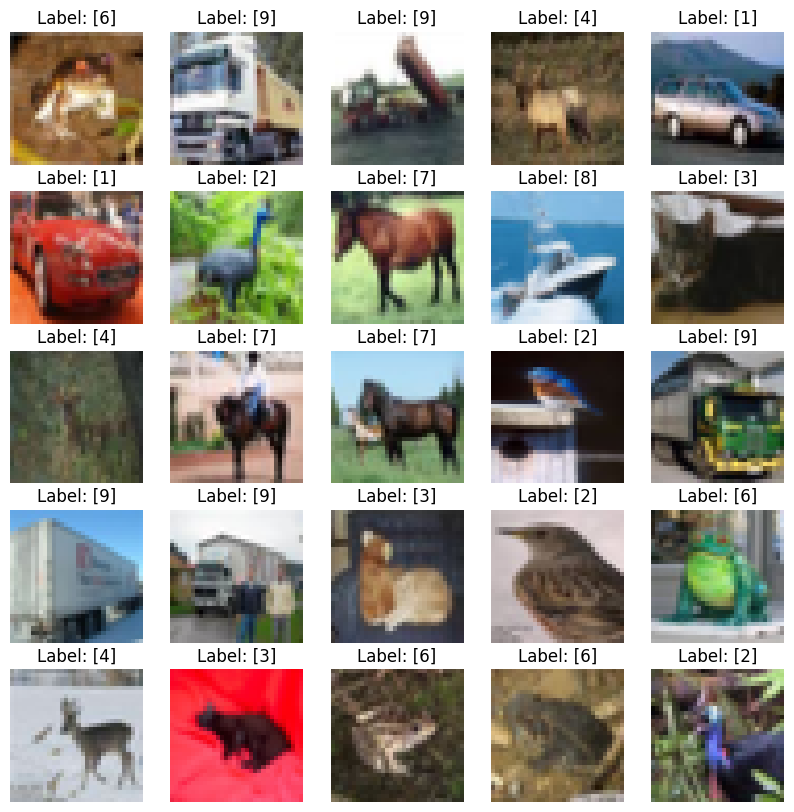

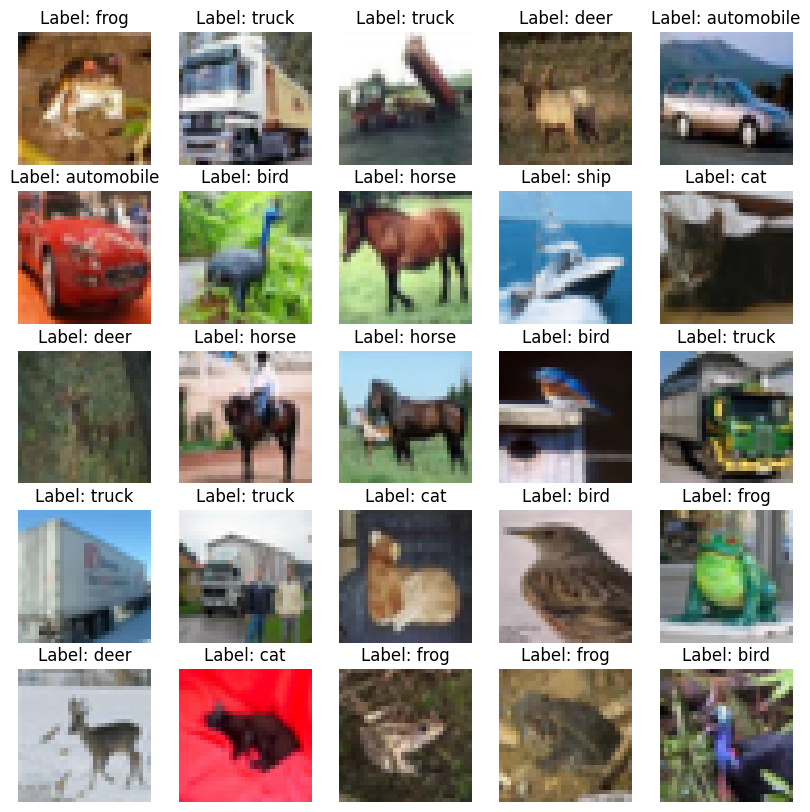

In [5]:
#visualize the first 25 images in the training set

plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i])
    plt.title(f"Label: {train_labels[i]}")
    plt.axis("off")
plt.show()

# change labels to class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Flatten labels if needed
train_labels = train_labels.flatten()

# visualize the random 25 images in the training set with class names
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i])
    plt.title(f"Label: {class_names[train_labels[i]]}")
    plt.axis("off")
plt.show()

## 3 - Preprocessing
Before training our model, we need to preprocess the data to ensure it is in the optimal format for learning. For image data, a common preprocessing step is normalization, which scales the pixel values to a range between 0 and 1. This helps the model train more efficiently and can lead to better performance. In this step, we normalize both the training and test images by dividing the pixel values by 255.

In [6]:
# Normalize the images to the range of [0, 1]
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# categorical labels
train_cat_labels = keras.utils.to_categorical(train_labels, num_classes=10)
test_cat_labels = keras.utils.to_categorical(test_labels, num_classes=10)
categorical = True


### Configurations & Callbacks

In [7]:
# No. of epochs
epochs_resnet = 100
epochs_conv = 50

# Loss
# Compile the model with an optimizer, loss function, and metrics
if categorical:
  loss = 'categorical_crossentropy'
else:
  loss = 'sparse_categorical_crossentropy'

# callbacks, early stopping
callback_es = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=30,
)

callback_rl= keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0,
)

checkpoint_filepath = 'model_checkpoints/exp1_{epoch:02d}_val_acc_{val_accuracy:.2f}.keras'

callback_cp = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks = [callback_es, callback_rl, callback_cp]


## 4 - Convolutional Neural Network
In this section, we will use a Convolutional Neural Network (CNN) to classify images from the CIFAR-10 dataset. CNNs are highly effective for image classification tasks because they can automatically learn spatial features from images. We will utilize the ResNet50 architecture, a powerful and widely used pretrained CNN model, to leverage transfer learning for improved performance. The model will be adapted to fit the CIFAR-10 dataset and trained on our preprocessed data.
The ResNet50 model is a deep convolutional neural network that has been pretrained on the ImageNet dataset.It is designed to extract features from images, which can be used for various image classification tasks.

### 4.1.1 - Intialize model Pretrained ResNet50
We initialize the ResNet50 model with pretrained ImageNet weights, set include_top=False to remove its original classifier, and specify the input shape as (32, 32, 3) for CIFAR-10 images. The base model's layers are frozen to retain learned features during training, enabling efficient transfer learning.

In [8]:
# Split training data for validation
x_train, x_val, y_train, y_val = train_test_split(
    train_images, train_cat_labels, test_size=0.2, random_state=42
)
"""
#Resize images to 224x224 (Resnet required size)
x_train = tf.image.resize(x_train, (224, 224))
x_val = tf.image.resize(x_val, (224, 224))
"""

# initialize the ResNet50 model with pretrained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base model to prevent its weights from being updated during training
base_model.trainable = False

### 4.1.2 - Creating on top of the base model
After initializing and freezing the ResNet50 base model, we build our customized classification head to adapt it for the CIFAR-10 dataset. First, a Global Average Pooling layer is added to reduce the output of the base model to a 1D vector, making it suitable for dense layers. Next, a fully connected (dense) layer with ReLU activation is included to learn complex patterns from the extracted features. A Dropout layer is added for regularization, to prevent overfitting by randomly dropping some connections during training. Finally, a dense output layer with softmax activation is to produce probability scores for each of the 10 CIFAR-10 classes. This approach leveragecan help to use the powerful feature extraction of ResNet50 while customizing the final classification for our specific task.

In [9]:
# Create a new model by stacking the base model and custom layers
# Base modem last layer has following dimensions: (None, 1, 1, 2048)
# Add custom layers on top of the base model which are fully connected layers for classification

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Global average pooling layer to reduce the spatial dimensions
    layers.Dense(256, activation='relu'),  # Fully connected layer with 256 units
    layers.Dense(128, activation='relu'),  # Fully connected layer with 128 units
    layers.Dense(64, activation='relu'),  # Output layer with 64 units
    layers.Dense(10, activation='softmax')  # Output layer with 10 units
])

### 4.1.3 - Compile Model


In [10]:
model.compile(optimizer='adam',
              loss=loss, #'sparse_categorical_crossentropy',
              metrics=['accuracy'])

### 4.1.4 - Train Model

In [11]:
# Train the model on the training data

history = model.fit(x_train, y_train,
                    #train_labels, # train_cat_labels
                    epochs=epochs_resnet,
                    batch_size=32,
                    validation_data=(x_val, y_val),  # Use 20% of the training data for validation
                    verbose=1,
                    callbacks=callbacks)  # Set verbose=1 to see training progress

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.1566 - loss: 2.2431 - val_accuracy: 0.2737 - val_loss: 1.9738 - learning_rate: 0.0010
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.2630 - loss: 1.9829 - val_accuracy: 0.2653 - val_loss: 2.0076 - learning_rate: 0.0010
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.2855 - loss: 1.9284 - val_accuracy: 0.3278 - val_loss: 1.8411 - learning_rate: 0.0010
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.3132 - loss: 1.8702 - val_accuracy: 0.3043 - val_loss: 1.9232 - learning_rate: 0.0010
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 51ms/step - accuracy: 0.3266 - loss: 1.8428 - val_accuracy: 0.3320 - val_loss: 1.8137 - learning_rate: 0.0010
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 49s 65ms/step - accuracy: 0.3426 - loss: 1.8091 - val_accuracy: 0.3588 - val_loss: 1.7749 - learning_rate: 0.0010
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 44s 59ms/step - accuracy: 0.3

Text(0.5, 1.0, 'Train - Accuracy')

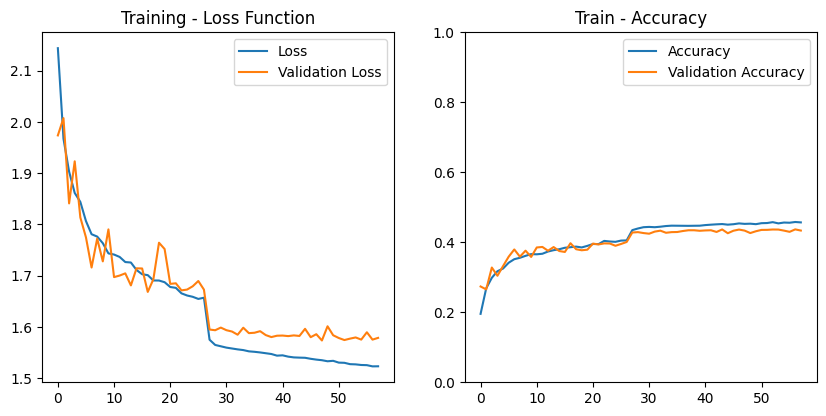

In [12]:
# Visualize the training and validation loss
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.ylim(0, 1)
plt.title('Train - Accuracy')

### 4.1.5 Evaluate model

313/313 - 15s - 46ms/step - accuracy: 0.4215 - loss: 1.6104
Available keys in history.history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


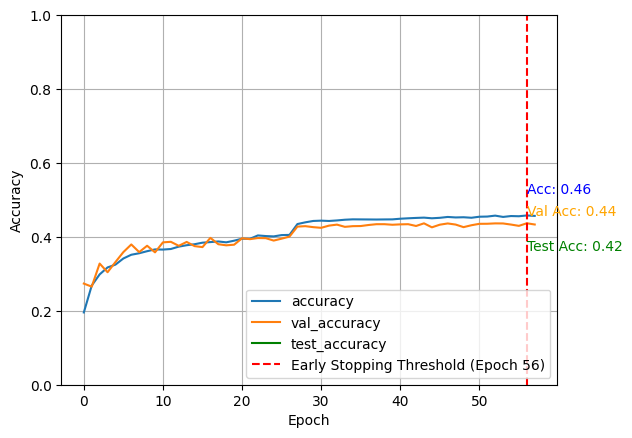

In [13]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_images, test_cat_labels, verbose=2) # test_labels.flatten()

# Check available keys in history.history
print("Available keys in history.history:", history.history.keys())

# Use the correct metric names for plotting
acc_key = 'accuracy' if 'accuracy' in history.history else 'acc'
val_acc_key = 'val_accuracy' if 'val_accuracy' in history.history else 'val_acc'

plt.plot(history.history[acc_key], label='accuracy')
plt.plot(history.history[val_acc_key], label='val_accuracy')
plt.plot(test_acc, label='test_accuracy', color='green')

# draw vertical line dynamically at best early stopping threshold
best_epoch = np.argmax(history.history['val_accuracy'])  # Find the epoch with the highest validation accuracy
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Early Stopping Threshold (Epoch {best_epoch})')
# show accuracy and validation accuracy at best epoch
epoch_best_acc = history.history[acc_key][best_epoch]
epoch_best_val_acc = history.history[val_acc_key][best_epoch]
plt.text(best_epoch, epoch_best_acc + 0.06, f'Acc: {epoch_best_acc:.2f}', color='blue', fontsize=10)
plt.text(best_epoch, epoch_best_val_acc + 0.02, f'Val Acc: {epoch_best_val_acc:.2f}', color='orange', fontsize=10)
plt.text(best_epoch, test_acc - 0.06, f'Test Acc: {test_acc:.2f}', color='green', fontsize=10)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid(True)
plt.show()







### 4.1.6 Insights
Trained model is evealuated on the test dataset to measure its generalization performance. The model achieves a test accuracy of approximately 43%, which is close to random guessing for 10 classes. This low accuracy, along with similar training and validation results, suggests that the model is not learning effectively from the data.
Possible reasons include issues with model configuration, insufficient training, or the need for further tuning and experimentation.

## 4.2 - Model_2
To improve 1st base model accuracy, Data augmentation is done, input is resized as Resnet was originally trained with (224,224), learning rate is reduced 0.0001.

### 4.2.1 Data Augmentation

In [14]:
# IMPROVEMENT 1: Add Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

### 4.2.2 Configuration and callbacks

In [15]:
# Training parameters
epochs_resnet = 20  # Reduced from 100
batch_size = 32
categorical = True

# Loss
if categorical:
    loss = 'categorical_crossentropy'
else:
    loss = 'sparse_categorical_crossentropy'

# Improved callbacks
callback_es = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=8,  # Reduced patience
    verbose=1,
    mode="auto",
    restore_best_weights=True,  # IMPORTANT: Set to True
    start_from_epoch=10,  # Start earlier
)

callback_rl = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,  # Less aggressive reduction
    patience=5,  # Reduced patience
    verbose=1,
    mode="auto",
    min_delta=0.001,
    cooldown=0,
    min_lr=1e-7,  # Set minimum learning rate
)

checkpoint_filepath = 'model_cp/exp2.model.keras'

callback_cp = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

callbacks = [callback_es, callback_rl, callback_cp]

### 4.2.3 Initialize Model 

In [16]:
# Split training data for validation

x_train, x_val, y_train, y_val = train_test_split(
    train_images, train_cat_labels, test_size=0.2, random_state=42
)

#Resize images to 224x224 (Resnet required size)
x_train_resized = tf.image.resize(x_train, (224, 224))
x_val_resized = tf.image.resize(x_val, (224, 224))

test_images_resized = tf.image.resize(test_images, (224, 224))




# initialize the ResNet50 model with pretrained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to prevent its weights from being updated during training
base_model.trainable = False

model_2 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Global average pooling layer to reduce the spatial dimensions
    layers.Dropout(0.3),  # Dropout layer for regularization
    layers.Dense(128, activation='relu'),  # Fully connected layer with 164 units
    layers.Dropout(0.2),  # Dropout layer for regularization
    layers.Dense(10, activation='softmax')  # Output layer with 10 units
])

### 4.2.4 Compile Model 

In [17]:
# Compile the model with an optimizer, loss function, and metrics
model_2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss=loss,
    metrics=['accuracy']
)

### 4.2.5 Train Model with Augmented data

In [18]:
# No augmentation for validation data
val_datagen = ImageDataGenerator()

# Create generators
train_generator = datagen.flow(x_train_resized, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(x_val_resized, y_val, batch_size=batch_size, shuffle=False)

# Use these generators in model.fit
history_2 = model_2.fit(
    train_generator,
    steps_per_epoch=len(x_train_resized) // batch_size,
    epochs=epochs_resnet,
    validation_data=val_generator,
    validation_steps=len(x_val_resized) // batch_size,
    verbose=1,
    callbacks=callbacks
)

/Users/amna/Documents/Data Analytics/Projects/4. Computer_Vision Project/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1020 - loss: 2.4507
Epoch 1: val_accuracy improved from -inf to 0.11631, saving model to model_cp/exp2.model.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 1403s 2s/step - accuracy: 0.1020 - loss: 2.4506 - val_accuracy: 0.1163 - val_loss: 2.2998 - learning_rate: 1.0000e-04
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1013 - loss: 2.3168
Epoch 2: val_accuracy did not improve from 0.11631
750/750 ━━━━━━━━━━━━━━━━━━━━ 1568s 2s/step - accuracy: 0.1013 - loss: 2.3167 - val_accuracy: 0.1013 - val_loss: 2.3016 - learning_rate: 1.0000e-04
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1049 - loss: 2.3041
Epoch 3: val_accuracy did not improve from 0.11631
750/750 ━━━━━━━━━━━━━━━━━━━━ 1837s 2s/step - accuracy: 0.1049 - loss: 2.3041 - val_accuracy: 0.1024 - val_loss: 2.3002 - learning_rate: 1.0000e-04
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1048 - loss: 2.3034
Epoch 4: val_accuracy 

Text(0.5, 1.0, 'Train - Accuracy')

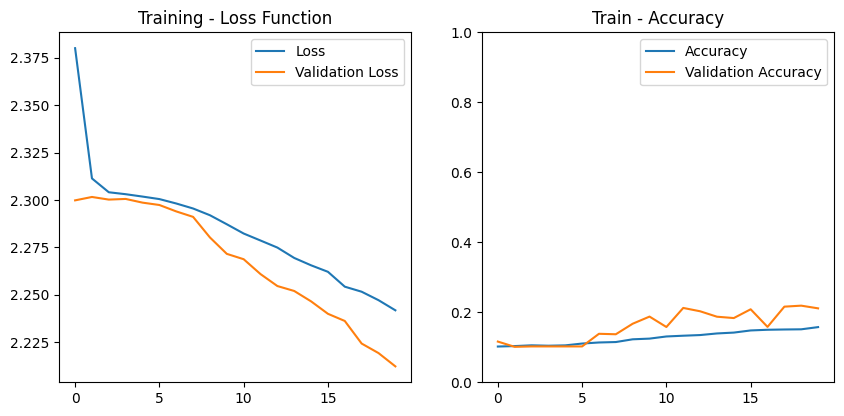

In [19]:
# Visualize the training and validation loss
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history_2.history['loss'], label='Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history_2.history['accuracy'], label='Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.ylim(0, 1)
plt.title('Train - Accuracy')

### 4.2.6 Evaluate model

313/313 - 396s - 1s/step - accuracy: 0.2042 - loss: 2.2150
Available keys in history_2.history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


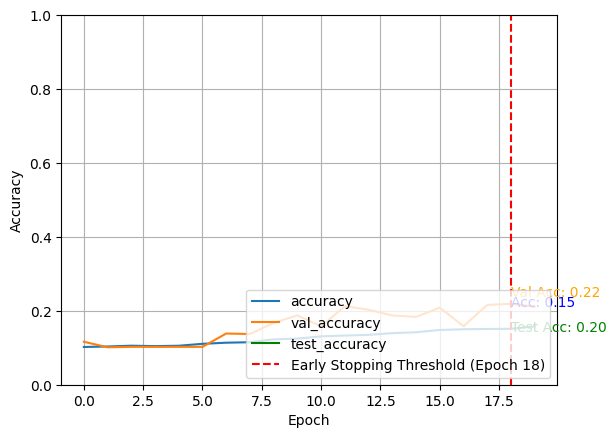

In [20]:
# Evaluate the model on the test data
test_loss_2, test_acc_2 = model_2.evaluate(test_images_resized, test_cat_labels, verbose=2)

# Check available keys in history_2.history
print("Available keys in history_2.history:", history_2.history.keys())

# Use the correct metric names for plotting
acc_key_2 = 'accuracy' if 'accuracy' in history_2.history else 'acc'
val_acc_key_2 = 'val_accuracy' if 'val_accuracy' in history_2.history else 'val_acc'

plt.plot(history_2.history[acc_key_2], label='accuracy')
plt.plot(history_2.history[val_acc_key_2], label='val_accuracy')
plt.plot(test_acc_2, label='test_accuracy', color='green')

# draw vertical line dynamically at best early stopping threshold
best_epoch_2 = np.argmax(history_2.history['val_accuracy'])  # Find the epoch with the highest validation accuracy
plt.axvline(x=best_epoch_2, color='r', linestyle='--', label=f'Early Stopping Threshold (Epoch {best_epoch_2})')
# show accuracy and validation accuracy at best epoch
epoch_best_acc_2 = history_2.history[acc_key_2][best_epoch_2]
epoch_best_val_acc_2 = history_2.history[val_acc_key_2][best_epoch_2]
plt.text(best_epoch_2, epoch_best_acc_2 + 0.06, f'Acc: {epoch_best_acc_2:.2f}', color='blue', fontsize=10)
plt.text(best_epoch_2, epoch_best_val_acc_2 + 0.02, f'Val Acc: {epoch_best_val_acc_2:.2f}', color='orange', fontsize=10)
plt.text(best_epoch_2, test_acc_2 - 0.06, f'Test Acc: {test_acc_2:.2f}', color='green', fontsize=10)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## 4.3 - Model_3
ResNet_50 is fine tuned and trained along the rest of customized fully connected layers of the model.


### 4.3.1 Model Intialize

In [21]:
# Split training data for validation
x_train, x_val, y_train, y_val = train_test_split(
    train_images, train_cat_labels, test_size=0.2, random_state=42
)
"""
#Resize images to 224x224 (Resnet required size)
x_train = tf.image.resize(x_train, (224, 224))
x_val = tf.image.resize(x_val, (224, 224))
"""

# initialize the ResNet50 model with pretrained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


print("\nStarting fine-tuning phase...")

# Unfreeze the base model
base_model.trainable = True

# Fine-tune from this layer onwards
#fine_tune_at = -20

# Freeze all layers before fine_tune_at
#for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable = False
    
model_3 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Global average pooling layer to reduce the spatial dimensions
    layers.Dense(256, activation='relu'),  # Fully connected layer with 256 units
    layers.Dropout(0.2),  # Dropout layer for regularization
    layers.Dense(128, activation='relu'),  # Fully connected layer with 128 units
    layers.Dropout(0.2),  # Dropout layer for regularization
    layers.Dense(64, activation='relu'),  # Fully connected layer with 64 units
    layers.Dropout(0.2),  # Dropout layer for regularization
    layers.Dense(10, activation='softmax')  # Output layer with 10 units
])


Starting fine-tuning phase...


### 4.3.2 - Compile Model


In [22]:
model_3.compile(optimizer='adam',
              loss=loss, #'sparse_categorical_crossentropy',
              metrics=['accuracy'])

### 4.3.3 - Train Model


In [23]:
checkpoint_filepath = 'model_cp/exp3.model.keras'

callback_cp = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

callbacks = [callback_es, callback_rl, callback_cp]

# Train the model on the training data

history_3= model_3.fit(x_train, y_train,
                    #train_labels, # train_cat_labels
                    epochs=epochs_resnet,
                    batch_size=32,
                    validation_data=(x_val, y_val),  # Use 20% of the training data for validation
                    verbose=1,
                    callbacks=callbacks)  # Set verbose=1 to see training progress

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.3145 - loss: 1.9905
Epoch 1: val_accuracy improved from -inf to 0.26300, saving model to model_cp/exp3.model.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 289s 371ms/step - accuracy: 0.3146 - loss: 1.9902 - val_accuracy: 0.2630 - val_loss: 2.1663 - learning_rate: 0.0010
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.4370 - loss: 1.6160
Epoch 2: val_accuracy improved from 0.26300 to 0.44817, saving model to model_cp/exp3.model.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 278s 370ms/step - accuracy: 0.4370 - loss: 1.6159 - val_accuracy: 0.4482 - val_loss: 1.5591 - learning_rate: 0.0010
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.5051 - loss: 1.4263
Epoch 3: val_accuracy did not improve from 0.44817
750/750 ━━━━━━━━━━━━━━━━━━━━ 277s 369ms/step - accuracy: 0.5051 - loss: 1.4263 - val_accuracy: 0.3973 - val_loss: 2.3382 - learning_rate: 0.0010
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - a

Text(0.5, 1.0, 'Train - Accuracy')

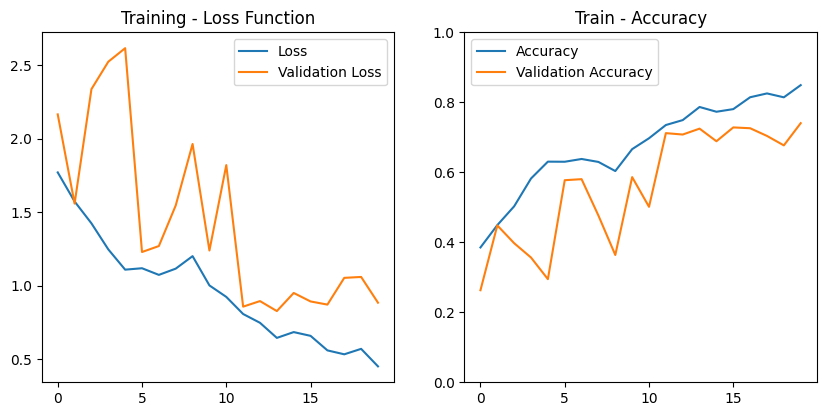

In [24]:
# Visualize the training and validation loss
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history_3.history['loss'], label='Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history_3.history['accuracy'], label='Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.ylim(0, 1)
plt.title('Train - Accuracy')

### 4.3.4 - Evaluate Model

313/313 - 11s - 35ms/step - accuracy: 0.7195 - loss: 0.8436
Available keys in history_3.history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


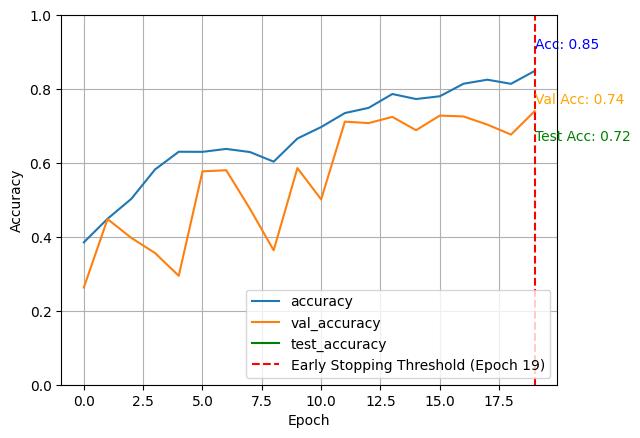

In [25]:
# Evaluate the model on the test data
test_loss_3, test_acc_3 = model_3.evaluate(test_images, test_cat_labels, verbose=2) # test_labels.flatten()

# Check available keys in history_3.history
print("Available keys in history_3.history:", history_3.history.keys())

# Use the correct metric names for plotting
acc_key_3 = 'accuracy' if 'accuracy' in history_3.history else 'acc'
val_acc_key_3 = 'val_accuracy' if 'val_accuracy' in history_3.history else 'val_acc'

plt.plot(history_3.history[acc_key_3], label='accuracy')
plt.plot(history_3.history[val_acc_key_3], label='val_accuracy')
plt.plot(test_acc_3, label='test_accuracy', color='green')

# draw vertical line dynamically at best early stopping threshold
best_epoch_3 = np.argmax(history_3.history['val_accuracy'])  # Find the epoch with the highest validation accuracy
plt.axvline(x=best_epoch_3, color='r', linestyle='--', label=f'Early Stopping Threshold (Epoch {best_epoch_3})')
# show accuracy and validation accuracy at best epoch
epoch_best_acc_3 = history_3.history[acc_key_3][best_epoch_3]
epoch_best_val_acc_3 = history_3.history[val_acc_key_3][best_epoch_3]
plt.text(best_epoch_3, epoch_best_acc_3 + 0.06, f'Acc: {epoch_best_acc_3:.2f}', color='blue', fontsize=10)
plt.text(best_epoch_3, epoch_best_val_acc_3 + 0.02, f'Val Acc: {epoch_best_val_acc_3:.2f}', color='orange', fontsize=10)
plt.text(best_epoch_3, test_acc_3 - 0.06, f'Test Acc: {test_acc_3:.2f}', color='green', fontsize=10)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## 5- Model_4
Convolutional Neural Network made from scratch, Without using a pretrained Resnet50.



### 5.1 - Intialize Model

In [26]:
# sequential model for convolutional neural network

model_4 = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
  

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

model_4.summary()

/Users/amna/Documents/Data Analytics/Projects/4. Computer_Vision Project/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 375,946 (1.43 MB)

 Trainable params: 375,946 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

### 5.2 - Compile Model

In [27]:
# Compile the model 
model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=loss, #'sparse_categorical_crossentropy',
                metrics=['accuracy'])

### 5.3 - Train Model

In [28]:
checkpoint_filepath = 'model_cp/exp4.model.keras'

callback_cp = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

callbacks = [callback_es, callback_rl, callback_cp]
# Train the model on the training data
history_4 = model_4.fit(x_train, y_train,
                        epochs=epochs_conv,
                        batch_size=32,
                        validation_data=(x_val, y_val),  # Use 20% of the training data for validation
                        verbose=1,
                        callbacks=callbacks)  # Set verbose=1 to see training progress

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.1762 - loss: 2.1537
Epoch 1: val_accuracy improved from -inf to 0.37350, saving model to model_cp/exp4.model.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 50s 65ms/step - accuracy: 0.1762 - loss: 2.1535 - val_accuracy: 0.3735 - val_loss: 1.7353 - learning_rate: 1.0000e-04
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3408 - loss: 1.7525
Epoch 2: val_accuracy improved from 0.37350 to 0.43900, saving model to model_cp/exp4.model.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 49s 66ms/step - accuracy: 0.3409 - loss: 1.7525 - val_accuracy: 0.4390 - val_loss: 1.5278 - learning_rate: 1.0000e-04
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4072 - loss: 1.6070
Epoch 3: val_accuracy improved from 0.43900 to 0.47683, saving model to model_cp/exp4.model.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 48s 64ms/step - accuracy: 0.4073 - loss: 1.6070 - val_accuracy: 0.4768 - val_loss: 1.4264 - learning_rate: 1.0000e-04
Epoch 4

Text(0.5, 1.0, 'Train - Accuracy')

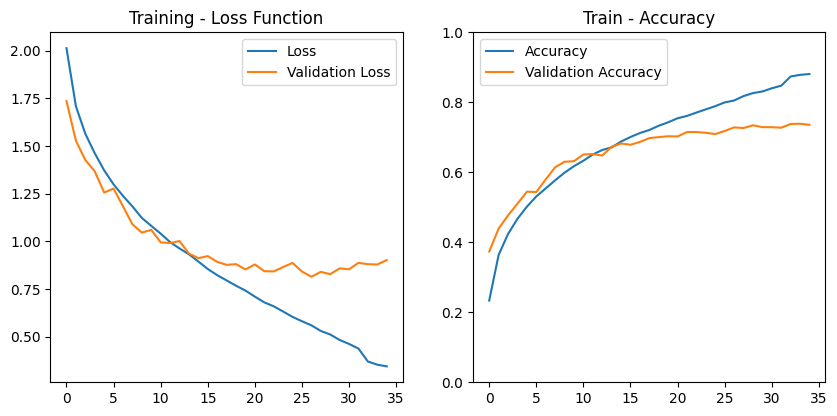

In [29]:
# Visualize the training and validation loss
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history_4.history['loss'], label='Loss')
plt.plot(history_4.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history_4.history['accuracy'], label='Accuracy')
plt.plot(history_4.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.ylim(0, 1)
plt.title('Train - Accuracy')

### 5.4- Evaluate Model

313/313 - 5s - 16ms/step - accuracy: 0.7203 - loss: 0.8372

Test accuracy: 0.720300018787384
Available keys in history_4.history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


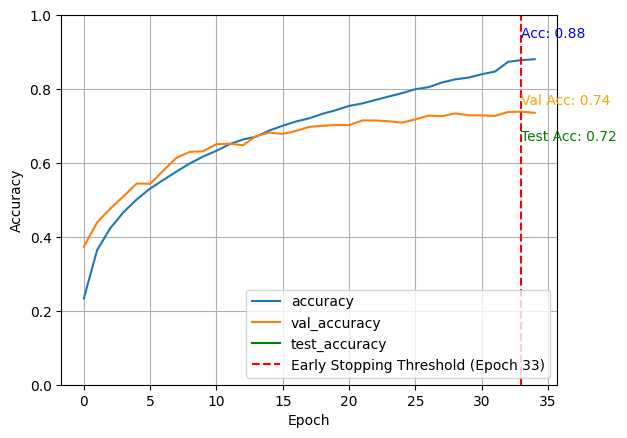

In [30]:
# Evaluate the model on the test data
test_loss_4, test_acc_4 = model_4.evaluate(test_images, test_cat_labels, verbose=2)
print("\nTest accuracy:", test_acc_4)

# Check available keys in history_4.history
print("Available keys in history_4.history:", history_4.history.keys())

# Use the correct metric names for plotting
acc_key_4 = 'accuracy' if 'accuracy' in history_4.history else 'acc'
val_acc_key_4 = 'val_accuracy' if 'val_accuracy' in history_4.history else 'val_acc'

plt.plot(history_4.history[acc_key_4], label='accuracy')
plt.plot(history_4.history[val_acc_key_4], label='val_accuracy')
plt.plot(test_acc_4, label='test_accuracy', color='green')

# draw vertical line dynamically at best early stopping threshold
best_epoch_4 = np.argmax(history_4.history['val_accuracy'])  # Find the epoch with the highest validation accuracy
plt.axvline(x=best_epoch_4, color='r', linestyle='--', label=f'Early Stopping Threshold (Epoch {best_epoch_4})')
# show accuracy and validation accuracy at best epoch
epoch_best_acc_4 = history_4.history[acc_key_4][best_epoch_4]
epoch_best_val_acc_4 = history_4.history[val_acc_key_4][best_epoch_4]
plt.text(best_epoch_4, epoch_best_acc_4 + 0.06, f'Acc: {epoch_best_acc_4:.2f}', color='blue', fontsize=10)
plt.text(best_epoch_4, epoch_best_val_acc_4 + 0.02, f'Val Acc: {epoch_best_val_acc_4:.2f}', color='orange', fontsize=10)
plt.text(best_epoch_4, test_acc_4 - 0.06, f'Test Acc: {test_acc_4:.2f}', color='green', fontsize=10)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# 6- Model Evaluation and Error Analysis

## 6.1- Comparison of all models

In [44]:
# print model training accuracy, validation accuracy and test accuracy for all models 1-4
model_train_acc = history.history['accuracy'][-1] 
model_val_acc = history.history['val_accuracy'][-1]
model_test_acc = model.evaluate(test_images, test_cat_labels, verbose=0)[1] 
print(f'Resnet50 Model: With Transfer Learning')
print(f"Model 1 - Train Accuracy: {model_train_acc:.2f}, Validation Accuracy: {model_val_acc:.2f}, Test Accuracy: {model_test_acc:.2f}")  

model_2_train_acc = history_2.history['accuracy'][-1] 
model_2_val_acc = history_2.history['val_accuracy'][-1]
model_2_test_acc = model_2.evaluate(test_images_resized, test_cat_labels, verbose=0)[1] 
print(f'ResNet50 Model: With Data Augmentation + Input Resizing to 224x224 + Transfer Learning')
print(f"Model 2 - Train Accuracy: {model_2_train_acc:.2f}, Validation Accuracy: {model_2_val_acc:.2f}, Test Accuracy: {model_2_test_acc:.2f}")  

model_3_train_acc = history_3.history['accuracy'][-1] 
model_3_val_acc = history_3.history['val_accuracy'][-1]
model_3_test_acc = model_3.evaluate(test_images, test_cat_labels, verbose=0)[1] 
print(f'ResNet50 Model: Transfer Learning with all layers unfrozen')
print(f"Model 3 - Train Accuracy: {model_3_train_acc:.2f}, Validation Accuracy: {model_3_val_acc:.2f}, Test Accuracy: {model_3_test_acc:.2f}")  

model_4_train_acc = history_4.history['accuracy'][-1] 
model_4_val_acc = history_4.history['val_accuracy'][-1]
model_4_test_acc = model_4.evaluate(test_images, test_cat_labels, verbose=0)[1] 
print(f'CNN Model from Scratch')
print(f"Model 4 - Train Accuracy: {model_4_train_acc:.2f}, Validation Accuracy: {model_4_val_acc:.2f}, Test Accuracy: {model_4_test_acc:.2f}")  


Resnet50 Model: With Transfer Learning
Model 1 - Train Accuracy: 0.46, Validation Accuracy: 0.43, Test Accuracy: 0.42
ResNet50 Model: With Data Augmentation + Input Resizing to 224x224 + Transfer Learning
Model 2 - Train Accuracy: 0.16, Validation Accuracy: 0.21, Test Accuracy: 0.20
ResNet50 Model: Transfer Learning with all layers unfrozen
Model 3 - Train Accuracy: 0.85, Validation Accuracy: 0.74, Test Accuracy: 0.72
CNN Model from Scratch
Model 4 - Train Accuracy: 0.88, Validation Accuracy: 0.74, Test Accuracy: 0.72


## 6.2- Error Analysis For Best performing Models

### 6.2.1- Model_3 

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step
              precision    recall  f1-score   support

    airplane       0.65      0.86      0.74      1000
  automobile       0.91      0.80      0.85      1000
        bird       0.63      0.57      0.60      1000
         cat       0.53      0.50      0.51      1000
        deer       0.72      0.68      0.70      1000
         dog       0.58      0.56      0.57      1000
        frog       0.78      0.78      0.78      1000
       horse       0.82      0.73      0.77      1000
        ship       0.77      0.89      0.83      1000
       truck       0.84      0.81      0.83      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



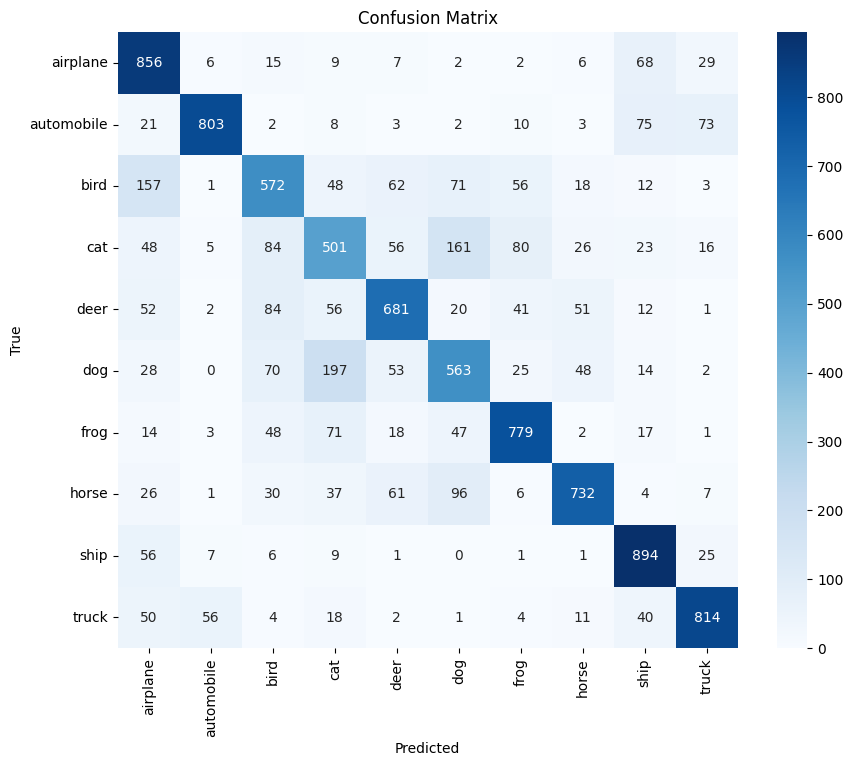

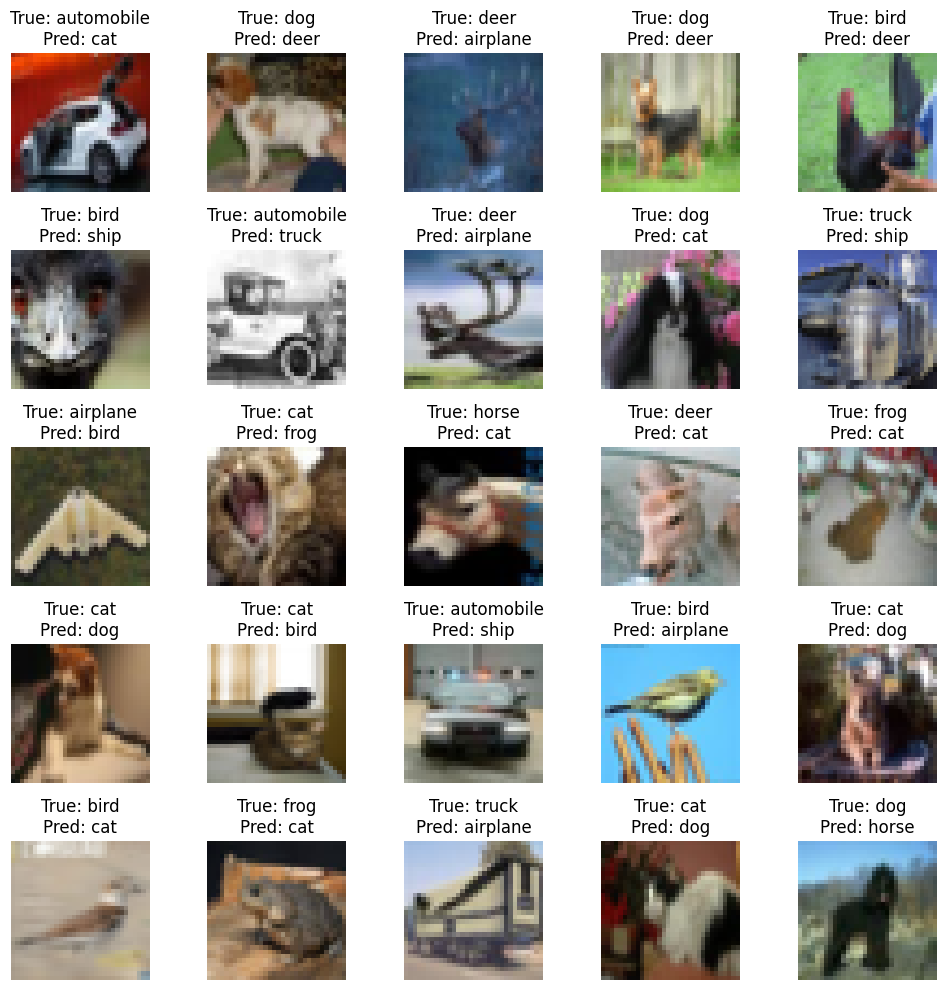

In [35]:
# Model evluation and error analysis
y_pred = model_3.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(test_labels, y_pred_classes, target_names=class_names))

# Confusion matrix

cm = confusion_matrix(test_labels, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()  

# Visualize some misclassified images
misclassified_indices = np.where(y_pred_classes != test_labels.flatten())[0]
num_misclassified = min(25, len(misclassified_indices))
plt.figure(figsize=(10, 10))
for i in range(num_misclassified):
    idx = misclassified_indices[i]
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[idx])
    plt.title(f"True: {class_names[test_labels[idx][0]]}\nPred: {class_names[y_pred_classes[idx]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


### 6.2.1- Model 4 

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
              precision    recall  f1-score   support

    airplane       0.70      0.82      0.75      1000
  automobile       0.85      0.87      0.86      1000
        bird       0.61      0.60      0.61      1000
         cat       0.51      0.54      0.53      1000
        deer       0.68      0.64      0.66      1000
         dog       0.61      0.61      0.61      1000
        frog       0.78      0.79      0.79      1000
       horse       0.80      0.75      0.77      1000
        ship       0.81      0.82      0.82      1000
       truck       0.88      0.76      0.81      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



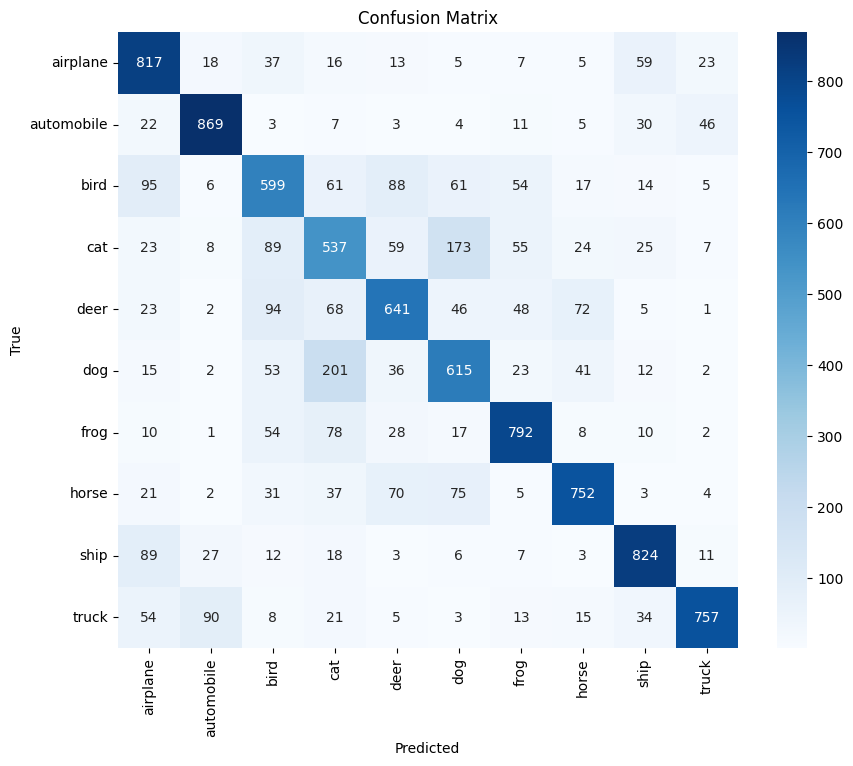

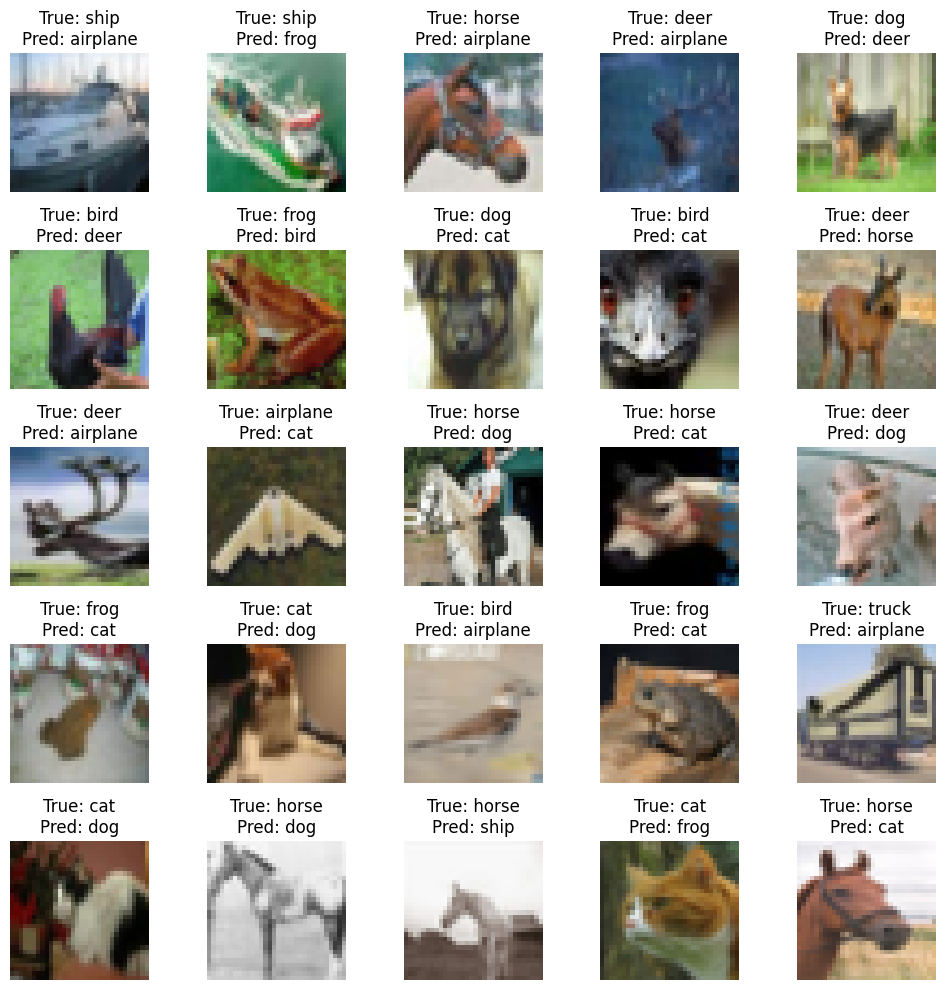

In [38]:
# Model evluation and error analysis
y_pred = model_4.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(test_labels, y_pred_classes, target_names=class_names))

# Confusion matrix

cm = confusion_matrix(test_labels, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()  

# Visualize some misclassified images
misclassified_indices = np.where(y_pred_classes != test_labels.flatten())[0]
num_misclassified = min(25, len(misclassified_indices))
plt.figure(figsize=(10, 10))
for i in range(num_misclassified):
    idx = misclassified_indices[i]
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[idx])
    plt.title(f"True: {class_names[test_labels[idx][0]]}\nPred: {class_names[y_pred_classes[idx]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# 7- Insights 

| Model Description                                                        | Train Accuracy | Validation Accuracy | Test Accuracy |
|--------------------------------------------------------------------------|:--------------:|:------------------:|:-------------:|
| **ResNet50 Model: With Transfer Learning**                               |     0.46       |        0.43        |     0.42      |
| **ResNet50 Model: With Data Augmentation + Input Resizing to 224x224**   |     0.16       |        0.21        |     0.20      |
| **ResNet50 Model: Transfer Learning with all layers unfrozen**           |     0.85       |        0.74        |     0.72      |
| **CNN Model from Scratch**                                               |     0.88       |        0.74        |     0.72      |

### Insights

- **Model 1 (ResNet50 Transfer Learning):**  
  Achieves moderate accuracy, showing the benefit of transfer learning, but is limited by not fine-tuning deeper layers.

- **Model 2 (ResNet50 + Data Augmentation + Resizing):**  
  Performs poorly, suggesting that data augmentation and resizing alone are not sufficient and may require further tuning or more training epochs.

- **Model 3 (ResNet50, all layers unfrozen):**  
  Fine-tuning the entire ResNet50 model leads to a significant boost in performance, indicating the importance of allowing the model to adapt to the new dataset.

- **Model 4 (Custom CNN from Scratch):**  
  Achieves the highest training accuracy and matches the fine-tuned ResNet50 on validation and test accuracy, demonstrating that a well-designed CNN can perform as well as transfer learning when trained properly.

## **Conclusion:**  
Fine-tuning pretrained models and designing effective custom architectures are both viable strategies for image classification. Data augmentation should be carefully tuned to avoid underfitting. Monitoring validation and test accuracy is crucial for assessing model generalization.

# 8- Save Model & Weights

In [1]:
import os

In [ ]:
# define relative path to the Models directory


models_dir = 'Models'
# Create the Models directory if it doesn't exist
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Save the model
model_3.save(os.path.join(models_dir, 'cifar10_model_3.h5'))

# Save the model history
with open(os.path.join(models_dir, 'cifar10_model_3_history.json'), 'w') as f:
    json.dump(history_3.history, f)
# Save the model architecture
model_json = model_3.to_json()
with open(os.path.join(models_dir, 'cifar10_model_3_architecture.json'), 'w') as json_file:
    json_file.write(model_json)

# Save the model with custom objects
model_3.save(os.path.join(models_dir, 'cifar10_model_3_custom.h5'), save_format='h5', include_optimizer=True)



In [ ]:
# Save the model
model_4.save('Models/cifar10_model_4.h5')
# Save the model history
with open('Models/cifar10_model_4_history.json', 'w') as f:
    json.dump(history_4.history, f)
# Save the model architecture
model_json = model_4.to_json()
with open('Models/cifar10_model_4_architecture.json', 'w') as json_file:
    json_file.write(model_json)

# Save the model with custom objects
model_4.save('Models/cifar10_model_4_custom.h5', save_format='h5', include_optimizer=True)

In [ ]:
# Load the model and weights
model_3_loaded = load_model('Models/cifar10_model_3.h5')
# Load the model history
with open('Models/cifar10_model_3_history.json', 'r') as f:
    history_3_loaded = json.load(f) 
# Load the model architecture
with open('Models/cifar10_model_3_architecture.json', 'r') as json_file:
    model_3_architecture = json_file.read()
